In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2 as cv
from datetime import datetime

import os
import segmentation_models_pytorch as smp

A:\Jupyter Files\envs\visual\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Data prep

In [3]:
JSON_FILE = r"HuBMAP dataset\polygons.jsonl"
IMG_PATH = r"HuBMAP dataset\imgs"
TILE_META_PATH = r"HuBMAP dataset\tile_meta.csv"

SEED = 42

In [4]:
class TileNineByNine(Dataset):
    
    def __init__(self, json_file=JSON_FILE,
                 images_path=IMG_PATH,
                 tile_meta_path=TILE_META_PATH,
                 wsi_n=1,
                 test=False):

        self.test = test
        self.wsi_n = wsi_n
        self.tile_meta = tile_meta_path
        self.polygons = json_file
        self.images_path = images_path

    def __len__(self):
        return len(self.polygons)

    @property
    def tile_meta(self):
        return self.__tile_meta

    @tile_meta.setter
    def tile_meta(self, val):
        with open(val) as f:
            tile_file = pd.read_csv(f)
            if self.test:
                tile_file = tile_file[tile_file.source_wsi == self.wsi_n].reset_index(drop=True)
            else:
                tile_file = tile_file[tile_file.source_wsi.isin([n for n in [1,2,3,4] if n!=self.wsi_n])].reset_index(drop=True)
            self.__tile_meta = tile_file

    @property
    def polygons(self):
        return self.__polygons

    @polygons.setter
    def polygons(self, val):
        with open(val) as f:
            polygons = pd.read_json(f, lines=True)
            polygons = polygons[polygons.id.isin(self.tile_meta.id)].reset_index(drop=True)
            self.__polygons = polygons
    
    def transformation(self, image, mask):
        
        need_crop = (image.shape[0] > 512)
        
        image = Image.fromarray(image)
        mask_img = Image.fromarray(mask)
        
        rotate_params = np.random.choice([0.0, 90.0, 180.0, 270.0, 0.0])
#         rotate_params = transforms.RandomRotation.get_params((-60, 60))
                
        flip = np.random.random()

        flip_v = np.random.random()

        jitter = np.random.random()
            
        if jitter > 0.5:
            image = transforms.ColorJitter(brightness=.5, hue=.3)(image)
            
        image = TF.rotate(image,rotate_params)
            
        if flip > 0.7:
            image = TF.hflip(image)
            
        if flip_v > 0.7:
            image = TF.vflip(image)       
        
        mask_img = TF.rotate(mask_img,rotate_params)
                
        if flip > 0.7:
            mask_img = TF.hflip(mask_img)
                
        if flip_v > 0.7:
            mask_img = TF.vflip(mask_img)
        
        input_image_size = (512, 512)
        
        if need_crop:
            crop_size = np.random.choice(range(412, 712)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)
        
        else:
            crop_size = np.random.choice(range(412, 512)) #1530
            crop_params = transforms.RandomCrop.get_params(image, [crop_size, crop_size])            
            image = TF.resized_crop(image,*crop_params,input_image_size)
            mask_img = TF.resized_crop(mask_img,*crop_params,input_image_size)

        mask = (np.array(mask_img))           
            
        return (image, mask)
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        img_name = self.polygons.iloc[index, 0]                              
        
        image = Image.open(os.path.join(self.images_path, img_name)+'.tif')
        
        image_large = np.zeros((512*3, 512*3, 3), dtype=np.uint8)
        mask_large = np.zeros((512*3, 512*3), dtype=np.uint8)

        n_wsi = self.tile_meta.source_wsi[self.tile_meta.id == img_name].item()

        self.df_wsi = self.tile_meta[self.tile_meta.source_wsi == n_wsi]
        
        col_coord, row_coord = self.df_wsi.i[self.tile_meta.id == img_name].item(), \
        self.tile_meta.j[self.tile_meta.id == img_name].item()

        init_row = row_coord - 512

        is_blank_flag = False

        y = 0
        for i in range(3):
            x=0
            init_col = col_coord - 512

            for j in range(3):
                
                image_small_name = self.df_wsi.id[np.logical_and((self.df_wsi.i == init_col),
                                                                    (self.df_wsi.j == init_row))]

                if image_small_name.empty or self.test:
                    is_blank_flag = True
                    image_large = np.array(image)
                    
                    mask_large = np.zeros((512, 512), dtype=np.uint8)
                    
                    for coord_dict in self.polygons.annotations[index]:
                        if coord_dict['type'] == 'blood_vessel':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=1)
        
                        if coord_dict['type'] == 'glomerulus':
                            pts = np.array(coord_dict['coordinates'][0])
                            cv.fillPoly(mask_large, pts=[pts], color=2)
                        
                    break

                image_small_path = os.path.join(self.images_path, image_small_name.item() + '.tif')
                
                with Image.open(image_small_path) as image_small:
                    image_large[y:y+512,x:x+512,:] = np.array(image_small)
                
                index_mask = self.polygons.index[self.polygons.id == image_small_name.item()].item()

                mask = np.zeros((512, 512), dtype=np.uint8)
                
                for coord_dict in self.polygons.annotations[index_mask]:
                    if coord_dict['type'] == 'blood_vessel':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=1)
        
                    if coord_dict['type'] == 'glomerulus':
                        pts = np.array(coord_dict['coordinates'][0])
                        cv.fillPoly(mask, pts=[pts], color=2)
                    
                mask_large[y:y+512,x:x+512] = mask   
                
                x += 512
                init_col += 512
                
            if is_blank_flag:
                break
            y += 512
            init_row += 512
            
        if not self.test:
            image_large, mask_large = self.transformation(image_large, mask_large)
        
        image_large = np.array(image_large).transpose((2, 0, 1))
        if image_large.max():
            image_large = image_large/image_large.max()
        
        image_large = norm(torch.tensor(image_large.astype(np.float32)))
        
        return image_large, mask_large.astype(np.float32)

In [5]:
# dataset = TileNineByNine(test=True, wsi_n=2)

In [6]:
def show_masked(img, mask):
#     img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
#     print(img.shape, mask.shape)
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)
    
    return(masked_img)
    
def img_denorm(x: np.ndarray) -> np.ndarray:
    """
    :param: normalized image with transforms.Normilize
    :return: numpy array with values 0 to 255
    """
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)
    
    return x

In [7]:
train_set = TileNineByNine()
test_set = TileNineByNine(test=True)

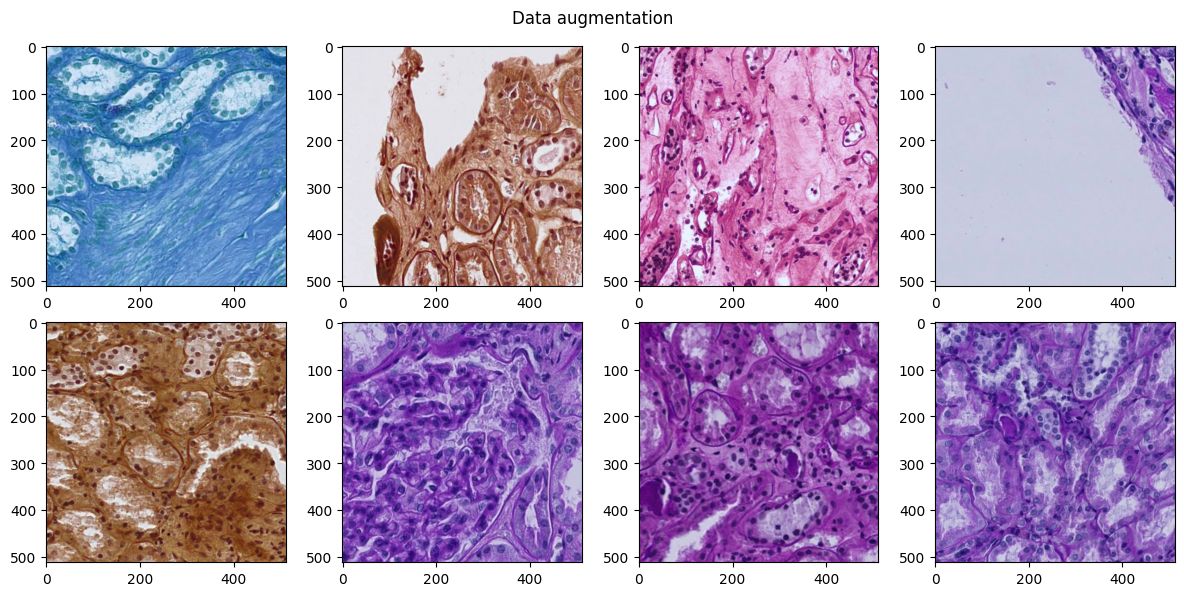

In [8]:
plot_row = 2
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(train_set))

        image = train_set[r_num][0]
        image = image.numpy().transpose((1,2,0))
        image = img_denorm(image)

        axs[i, j].imshow(image)

fig.suptitle('Data augmentation')
plt.show()

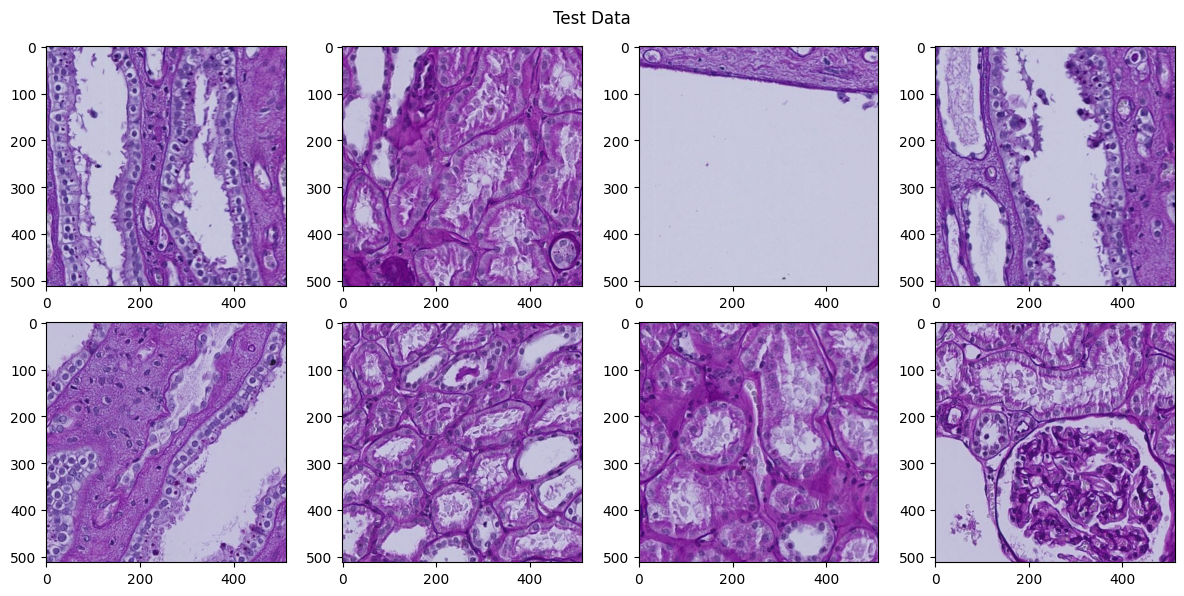

In [9]:
plot_row = 2
plot_col = 4

fig, axs = plt.subplots(plot_row, plot_col, figsize=(12,6), layout='tight')

for i in range(plot_row):
    for j in range(plot_col):
        r_num = np.random.randint(0, len(test_set))

        image = test_set[r_num][0]
        image = image.numpy().transpose((1,2,0))
        image = img_denorm(image)

        axs[i, j].imshow(image)

fig.suptitle('Test Data')
plt.show()

## MODEL and training
For model evaluation I use 4-fold CV, with each WSI as fold (check out [Data preprocess notebook](https://github.com/shmak2000/HuBMAP_med_image_segmantation/blob/6f2f3349737715dedc8efdd008168afa061e9d70/Data%20preprocess%20analysis.ipynb))

In [10]:
def moving_average(array: np.array, betta=0.9) -> np.array:
    """
    Computing moving average with bias correction.
    """

    V = 0
    average_array = np.zeros(len(array))
    for i in range(len(array)):
        V = betta * V + (1 - betta) * array[i]
        average_array[i] = V/(1 - pow(betta, i+1))

    return average_array

def init_dataloaders(wsi_n, batch_size):

    train_data = TileNineByNine(test=False, wsi_n=wsi_n)
    test_data = TileNineByNine(test=True, wsi_n=wsi_n)

    train_len = int(len(train_data)*0.9)
    train_dev_len = len(train_data) - train_len

    train_data, train_dev_data = random_split(train_data, [train_len, train_dev_len])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    train_dev_loader = DataLoader(train_dev_data, batch_size=batch_size, shuffle=True, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

    return train_loader, test_loader, train_dev_loader

def train_model(model, loss_func_focal, loss_func_dice, n_epochs, lr, wd, gamma, wsi_n):

    best_score = 0
    best_epoch = 0
    warmup_steps = 7

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma, verbose=True)
    warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, 2e-02, 1, warmup_steps, verbose=True)
    scaler = torch.cuda.amp.GradScaler()
    model.to(device)

    losses_train = np.zeros(n_epochs)
    losses_test = np.zeros(n_epochs)
    losses_train_dev = np.zeros(n_epochs)

    iou_test = np.zeros(n_epochs)
    iou_train_dev = np.zeros(n_epochs)
    iou_all = np.zeros(n_epochs)

    for i in range(n_epochs):
        model.train()
        losses_epoch_train = []

        t0 = datetime.now()

        for inputs, targets in tqdm(train_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()

            optimizer.zero_grad()

            with torch.autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(inputs)
                loss = 0.7*loss_func_dice(outputs, targets) + loss_func_focal(outputs, targets)
                # loss = loss_func(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)

            scaler.update()

            losses_epoch_train.append(loss.item())

        if i < warmup_steps:
            warmup_scheduler.step()
        else:
            lr_scheduler.step()

        losses_test[i], iou_test[i], losses_train_dev[i],\
        iou_train_dev[i], iou_all[i] = test_model(model, loss_func_focal, loss_func_dice)

        losses_train[i] = np.mean(losses_epoch_train)

        if iou_test[i] == np.max(iou_test[:i+1]):
            torch.save(model.state_dict(), r'models\cv\best__wsi{}.pt'.format(wsi_n))
            best_score = iou_test[i]
            best_epoch = i
            print(f'Best saved, IoU: {iou_test[i]:.3f}')

        if n_epochs > 100 and i == 100:
            torch.save(model.state_dict(), '100_epochs__.pt')
            print(f'100 epochs weights saved!')

        dt = datetime.now() - t0

        print(f'WSI #{wsi_n}, Epoch: {i+1}/{n_epochs}')
        print(f'Train loss: {losses_train[i]:.3f} Test loss: {losses_test[i]:.3f}, Train-dev loss: {losses_train_dev[i]:.3f}')
        print(f'Time: {dt}, IoU 1 class test: {iou_test[i]:.3f}, IoU train-dev: {iou_train_dev[i]:.3f}')
        print(f'IoU all classes test: {iou_all[i]:.3f}')
        torch.cuda.empty_cache()

        train_res = {'losses_train': losses_train, 'losses_test': losses_test,
                     'losses_train_dev': losses_train_dev, 'iou_test': iou_test,
                     'iou_train_dev': iou_train_dev, 'iou_all': iou_all,
                     'best_score': best_score, 'best_epoch': best_epoch}

    return train_res

def test_model(model, loss_func_focal, loss_func_dice):

    metrics_all_classes = torchmetrics.JaccardIndex(task='multiclass', num_classes=3)
    metrics = torchmetrics.JaccardIndex(task='binary')

    metrics.to(device)
    metrics_all_classes.to(device)

    losses_epoch_test = []
    iou = []
    iou_all_classes = []
    iou_2class_test = []

    model.eval()

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()

            outputs = model(inputs)
            loss = 0.7*loss_func_dice(outputs, targets) + loss_func_focal(outputs, targets)
            # loss = loss_func(outputs, targets)

            zrs = np.zeros(targets.shape, dtype=np.float32)
            zrs[targets.cpu().numpy()==1] = 1
            zrs = torch.tensor(zrs).to(device)

            zrs_2 = np.zeros(targets.shape, dtype=np.float32)
            zrs_2[targets.cpu().numpy()==2] = 1
            zrs_2 = torch.tensor(zrs_2).to(device)

            iou.append(metrics(outputs[:,1,:,:], zrs).item())
            iou_2class_test.append(metrics(outputs[:,2,:,:], zrs_2).item())
            iou_all_classes.append(metrics_all_classes(outputs, targets).item())

            losses_epoch_test.append(loss.item())

    losses_train_dev = []
    iou_train_dev = []

    with torch.no_grad():
        for inputs, targets in tqdm(train_dev_loader):
            targets = targets.type(torch.LongTensor)
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()

            outputs = model(inputs)
            # loss = loss_func(outputs, targets)
            loss = 0.7*loss_func_dice(outputs, targets) + loss_func_focal(outputs, targets)

            zrs = np.zeros(targets.shape, dtype=np.float32)
            zrs[targets.cpu().numpy()==1] = 1
            zrs = torch.tensor(zrs).to(device)

            iou_train_dev.append(metrics(outputs[:,1,:,:], zrs).item())
            losses_train_dev.append(loss.item())

    return np.mean(losses_epoch_test), np.nanmean(iou), np.mean(losses_train_dev),\
           np.nanmean(iou_train_dev), np.nanmean(iou_all_classes)

def axis_loss_set(ax, train_res):

    ax.plot(train_res['losses_test'], label='test')
    ax.plot(moving_average(train_res['losses_test']), label='m/a_test')
    ax.plot(train_res['losses_train'], label='train')
    ax.plot(moving_average(train_res['losses_train']), label='m/a_train')

    ax.plot(train_res['losses_train_dev'], label='train-dev', linestyle='dotted')

    ax.set_title(f"#{WSI}, scr:{train_res['losses_test'][-1]:.4f}", loc='left')
    ax.legend()

    return ax

def axis_iou_set(ax, train_res, score):

    ax.plot(train_res['iou_test'], label='test')
    ax.plot(moving_average(train_res['iou_test']), label='m/a_iou')
    ax.plot(train_res['iou_train_dev'], label='train-dev', linestyle='dotted')
    ax.plot(train_res['iou_all'], label='all cls')
    ax.scatter(train_res['best_epoch'], train_res['best_score'], label='max', color='r')

    ax.set_title(f"#{WSI}, scr:{score:.4f}, best:{train_res['best_score']:.4f}", loc='left')
    ax.legend()

    return ax

Adjusting learning rate of group 0 to 1.1000e-04.
Adjusting learning rate of group 0 to 2.2000e-06.


100%|██████████| 202/202 [02:37<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 1.7600e-05.


100%|██████████| 22/22 [00:14<00:00,  1.52it/s]


Best saved, IoU: 0.045
WSI #1, Epoch: 1/50
Train loss: 1.247 Test loss: 1.163, Train-dev loss: 1.188
Time: 0:03:11.915525, IoU 1 class test: 0.045, IoU train-dev: 0.046
IoU all classes test: 0.130


100%|██████████| 202/202 [02:26<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 3.3000e-05.


100%|██████████| 22/22 [00:14<00:00,  1.49it/s]


WSI #1, Epoch: 2/50
Train loss: 1.077 Test loss: 0.944, Train-dev loss: 1.013
Time: 0:03:10.236490, IoU 1 class test: 0.001, IoU train-dev: 0.009
IoU all classes test: 0.312


100%|██████████| 202/202 [02:24<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 4.8400e-05.


100%|██████████| 22/22 [00:15<00:00,  1.46it/s]


WSI #1, Epoch: 3/50
Train loss: 0.967 Test loss: 0.866, Train-dev loss: 0.939
Time: 0:03:11.371665, IoU 1 class test: 0.001, IoU train-dev: 0.003
IoU all classes test: 0.420


100%|██████████| 202/202 [02:26<00:00,  1.38it/s]


Adjusting learning rate of group 0 to 6.3800e-05.


100%|██████████| 22/22 [00:15<00:00,  1.38it/s]


WSI #1, Epoch: 4/50
Train loss: 0.918 Test loss: 0.847, Train-dev loss: 0.884
Time: 0:03:13.955711, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.397


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


Adjusting learning rate of group 0 to 7.9200e-05.


100%|██████████| 22/22 [00:15<00:00,  1.38it/s]


WSI #1, Epoch: 5/50
Train loss: 0.900 Test loss: 0.819, Train-dev loss: 0.852
Time: 0:03:09.804390, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.510


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


Adjusting learning rate of group 0 to 9.4600e-05.


100%|██████████| 22/22 [00:17<00:00,  1.27it/s]


Best saved, IoU: 0.084
WSI #1, Epoch: 6/50
Train loss: 0.874 Test loss: 0.802, Train-dev loss: 0.876
Time: 0:03:09.921315, IoU 1 class test: 0.084, IoU train-dev: 0.058
IoU all classes test: 0.556


100%|██████████| 202/202 [02:24<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 1.1000e-04.


100%|██████████| 22/22 [00:17<00:00,  1.28it/s]


Best saved, IoU: 0.297
WSI #1, Epoch: 7/50
Train loss: 0.859 Test loss: 0.799, Train-dev loss: 0.837
Time: 0:03:13.657971, IoU 1 class test: 0.297, IoU train-dev: 0.287
IoU all classes test: 0.629


100%|██████████| 202/202 [02:22<00:00,  1.42it/s]


Adjusting learning rate of group 0 to 1.0890e-04.


100%|██████████| 22/22 [00:15<00:00,  1.38it/s]


Best saved, IoU: 0.318
WSI #1, Epoch: 8/50
Train loss: 0.853 Test loss: 0.777, Train-dev loss: 0.853
Time: 0:03:09.604232, IoU 1 class test: 0.318, IoU train-dev: 0.347
IoU all classes test: 0.629


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 1.0781e-04.


100%|██████████| 22/22 [00:16<00:00,  1.32it/s]


Best saved, IoU: 0.360
WSI #1, Epoch: 9/50
Train loss: 0.855 Test loss: 0.788, Train-dev loss: 0.849
Time: 0:03:11.118290, IoU 1 class test: 0.360, IoU train-dev: 0.375
IoU all classes test: 0.675


100%|██████████| 202/202 [02:24<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 1.0673e-04.


100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


WSI #1, Epoch: 10/50
Train loss: 0.837 Test loss: 0.800, Train-dev loss: 0.835
Time: 0:03:12.185797, IoU 1 class test: 0.334, IoU train-dev: 0.386
IoU all classes test: 0.665


100%|██████████| 202/202 [02:21<00:00,  1.42it/s]


Adjusting learning rate of group 0 to 1.0567e-04.


100%|██████████| 22/22 [00:16<00:00,  1.32it/s]


WSI #1, Epoch: 11/50
Train loss: 0.837 Test loss: 0.788, Train-dev loss: 0.832
Time: 0:03:09.227002, IoU 1 class test: 0.337, IoU train-dev: 0.423
IoU all classes test: 0.588


100%|██████████| 202/202 [02:19<00:00,  1.44it/s]


Adjusting learning rate of group 0 to 1.0461e-04.


100%|██████████| 22/22 [00:15<00:00,  1.44it/s]


WSI #1, Epoch: 12/50
Train loss: 0.840 Test loss: 0.802, Train-dev loss: 0.841
Time: 0:03:05.992479, IoU 1 class test: 0.310, IoU train-dev: 0.373
IoU all classes test: 0.653


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 1.0356e-04.


100%|██████████| 22/22 [00:16<00:00,  1.36it/s]


WSI #1, Epoch: 13/50
Train loss: 0.835 Test loss: 0.822, Train-dev loss: 0.845
Time: 0:03:10.483617, IoU 1 class test: 0.249, IoU train-dev: 0.398
IoU all classes test: 0.565


100%|██████████| 202/202 [02:20<00:00,  1.44it/s]


Adjusting learning rate of group 0 to 1.0253e-04.


100%|██████████| 22/22 [00:14<00:00,  1.53it/s]


WSI #1, Epoch: 14/50
Train loss: 0.830 Test loss: 0.797, Train-dev loss: 0.857
Time: 0:03:05.550019, IoU 1 class test: 0.332, IoU train-dev: 0.401
IoU all classes test: 0.658


100%|██████████| 202/202 [02:21<00:00,  1.43it/s]


Adjusting learning rate of group 0 to 1.0150e-04.


100%|██████████| 22/22 [00:14<00:00,  1.50it/s]


WSI #1, Epoch: 15/50
Train loss: 0.838 Test loss: 0.795, Train-dev loss: 0.837
Time: 0:03:07.124693, IoU 1 class test: 0.354, IoU train-dev: 0.427
IoU all classes test: 0.685


100%|██████████| 202/202 [02:24<00:00,  1.39it/s]


Adjusting learning rate of group 0 to 1.0049e-04.


100%|██████████| 22/22 [00:16<00:00,  1.37it/s]


WSI #1, Epoch: 16/50
Train loss: 0.832 Test loss: 0.806, Train-dev loss: 0.808
Time: 0:03:11.849963, IoU 1 class test: 0.325, IoU train-dev: 0.430
IoU all classes test: 0.671


100%|██████████| 202/202 [02:24<00:00,  1.40it/s]


Adjusting learning rate of group 0 to 9.9482e-05.


100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


Best saved, IoU: 0.411
WSI #1, Epoch: 17/50
Train loss: 0.830 Test loss: 0.789, Train-dev loss: 0.846
Time: 0:03:12.369086, IoU 1 class test: 0.411, IoU train-dev: 0.423
IoU all classes test: 0.699


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 9.8487e-05.


100%|██████████| 22/22 [00:16<00:00,  1.34it/s]


WSI #1, Epoch: 18/50
Train loss: 0.829 Test loss: 0.791, Train-dev loss: 0.833
Time: 0:03:10.549380, IoU 1 class test: 0.358, IoU train-dev: 0.419
IoU all classes test: 0.670


100%|██████████| 202/202 [02:23<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 9.7502e-05.


100%|██████████| 22/22 [00:15<00:00,  1.45it/s]


WSI #1, Epoch: 19/50
Train loss: 0.832 Test loss: 0.793, Train-dev loss: 0.818
Time: 0:03:08.782366, IoU 1 class test: 0.383, IoU train-dev: 0.454
IoU all classes test: 0.624


100%|██████████| 202/202 [02:22<00:00,  1.41it/s]


Adjusting learning rate of group 0 to 9.6527e-05.


100%|██████████| 22/22 [00:15<00:00,  1.38it/s]


WSI #1, Epoch: 20/50
Train loss: 0.831 Test loss: 0.781, Train-dev loss: 0.803
Time: 0:03:09.902471, IoU 1 class test: 0.314, IoU train-dev: 0.444
IoU all classes test: 0.649


100%|██████████| 202/202 [02:54<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 9.5562e-05.


100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


WSI #1, Epoch: 21/50
Train loss: 0.821 Test loss: 0.780, Train-dev loss: 0.825
Time: 0:03:47.627665, IoU 1 class test: 0.393, IoU train-dev: 0.440
IoU all classes test: 0.698


100%|██████████| 202/202 [03:00<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.4606e-05.


100%|██████████| 22/22 [00:20<00:00,  1.09it/s]


Best saved, IoU: 0.425
WSI #1, Epoch: 22/50
Train loss: 0.823 Test loss: 0.777, Train-dev loss: 0.817
Time: 0:03:55.667589, IoU 1 class test: 0.425, IoU train-dev: 0.459
IoU all classes test: 0.701


100%|██████████| 202/202 [02:58<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.3660e-05.


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


WSI #1, Epoch: 23/50
Train loss: 0.830 Test loss: 0.784, Train-dev loss: 0.838
Time: 0:03:53.261158, IoU 1 class test: 0.367, IoU train-dev: 0.438
IoU all classes test: 0.697


100%|██████████| 202/202 [02:58<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.2724e-05.


100%|██████████| 22/22 [00:19<00:00,  1.11it/s]


WSI #1, Epoch: 24/50
Train loss: 0.828 Test loss: 0.780, Train-dev loss: 0.817
Time: 0:03:52.677612, IoU 1 class test: 0.383, IoU train-dev: 0.473
IoU all classes test: 0.691


100%|██████████| 202/202 [02:59<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.1797e-05.


100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


WSI #1, Epoch: 25/50
Train loss: 0.826 Test loss: 0.792, Train-dev loss: 0.839
Time: 0:03:53.156008, IoU 1 class test: 0.402, IoU train-dev: 0.448
IoU all classes test: 0.712


100%|██████████| 202/202 [02:55<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 9.0879e-05.


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


WSI #1, Epoch: 26/50
Train loss: 0.830 Test loss: 0.785, Train-dev loss: 0.801
Time: 0:03:51.095918, IoU 1 class test: 0.341, IoU train-dev: 0.418
IoU all classes test: 0.652


100%|██████████| 202/202 [02:53<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 8.9970e-05.


100%|██████████| 22/22 [00:18<00:00,  1.17it/s]


Best saved, IoU: 0.437
WSI #1, Epoch: 27/50
Train loss: 0.825 Test loss: 0.770, Train-dev loss: 0.816
Time: 0:03:47.101584, IoU 1 class test: 0.437, IoU train-dev: 0.481
IoU all classes test: 0.692


100%|██████████| 202/202 [03:00<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.9070e-05.


100%|██████████| 22/22 [00:20<00:00,  1.09it/s]


Best saved, IoU: 0.452
WSI #1, Epoch: 28/50
Train loss: 0.830 Test loss: 0.774, Train-dev loss: 0.851
Time: 0:03:54.096359, IoU 1 class test: 0.452, IoU train-dev: 0.472
IoU all classes test: 0.709


100%|██████████| 202/202 [03:01<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 8.8179e-05.


100%|██████████| 22/22 [00:21<00:00,  1.04it/s]


WSI #1, Epoch: 29/50
Train loss: 0.815 Test loss: 0.786, Train-dev loss: 0.816
Time: 0:03:55.654892, IoU 1 class test: 0.443, IoU train-dev: 0.466
IoU all classes test: 0.736


100%|██████████| 202/202 [03:01<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.7298e-05.


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


WSI #1, Epoch: 30/50
Train loss: 0.831 Test loss: 0.785, Train-dev loss: 0.805
Time: 0:03:56.094937, IoU 1 class test: 0.349, IoU train-dev: 0.492
IoU all classes test: 0.681


100%|██████████| 202/202 [03:08<00:00,  1.07it/s]


Adjusting learning rate of group 0 to 8.6425e-05.


100%|██████████| 22/22 [00:18<00:00,  1.19it/s]


WSI #1, Epoch: 31/50
Train loss: 0.828 Test loss: 0.778, Train-dev loss: 0.818
Time: 0:04:00.352526, IoU 1 class test: 0.416, IoU train-dev: 0.479
IoU all classes test: 0.705


100%|██████████| 202/202 [02:49<00:00,  1.19it/s]


Adjusting learning rate of group 0 to 8.5560e-05.


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


WSI #1, Epoch: 32/50
Train loss: 0.824 Test loss: 0.800, Train-dev loss: 0.826
Time: 0:03:45.167014, IoU 1 class test: 0.349, IoU train-dev: 0.503
IoU all classes test: 0.648


100%|██████████| 202/202 [02:59<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.4705e-05.


100%|██████████| 22/22 [00:19<00:00,  1.11it/s]


WSI #1, Epoch: 33/50
Train loss: 0.827 Test loss: 0.775, Train-dev loss: 0.795
Time: 0:03:53.334577, IoU 1 class test: 0.436, IoU train-dev: 0.469
IoU all classes test: 0.716


100%|██████████| 202/202 [03:05<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 8.3858e-05.


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


WSI #1, Epoch: 34/50
Train loss: 0.831 Test loss: 0.772, Train-dev loss: 0.791
Time: 0:04:00.564668, IoU 1 class test: 0.394, IoU train-dev: 0.446
IoU all classes test: 0.670


100%|██████████| 202/202 [03:01<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.3019e-05.


100%|██████████| 22/22 [00:19<00:00,  1.13it/s]


WSI #1, Epoch: 35/50
Train loss: 0.824 Test loss: 0.783, Train-dev loss: 0.831
Time: 0:03:54.392901, IoU 1 class test: 0.390, IoU train-dev: 0.462
IoU all classes test: 0.702


100%|██████████| 202/202 [02:55<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 8.2189e-05.


100%|██████████| 22/22 [00:21<00:00,  1.03it/s]


WSI #1, Epoch: 36/50
Train loss: 0.829 Test loss: 0.853, Train-dev loss: 0.851
Time: 0:03:50.621211, IoU 1 class test: 0.248, IoU train-dev: 0.399
IoU all classes test: 0.604


100%|██████████| 202/202 [03:00<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.1367e-05.


100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


WSI #1, Epoch: 37/50
Train loss: 0.825 Test loss: 0.781, Train-dev loss: 0.815
Time: 0:03:57.466401, IoU 1 class test: 0.422, IoU train-dev: 0.478
IoU all classes test: 0.700


100%|██████████| 202/202 [03:00<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.0553e-05.


100%|██████████| 22/22 [00:19<00:00,  1.11it/s]


WSI #1, Epoch: 38/50
Train loss: 0.826 Test loss: 0.778, Train-dev loss: 0.819
Time: 0:03:54.374759, IoU 1 class test: 0.438, IoU train-dev: 0.480
IoU all classes test: 0.720


100%|██████████| 202/202 [03:01<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 7.9748e-05.


100%|██████████| 22/22 [00:18<00:00,  1.16it/s]


WSI #1, Epoch: 39/50
Train loss: 0.825 Test loss: 0.780, Train-dev loss: 0.843
Time: 0:03:54.577457, IoU 1 class test: 0.443, IoU train-dev: 0.480
IoU all classes test: 0.736


100%|██████████| 202/202 [02:58<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.8950e-05.


100%|██████████| 22/22 [00:19<00:00,  1.14it/s]


WSI #1, Epoch: 40/50
Train loss: 0.828 Test loss: 0.775, Train-dev loss: 0.817
Time: 0:03:52.144302, IoU 1 class test: 0.426, IoU train-dev: 0.506
IoU all classes test: 0.699


100%|██████████| 202/202 [02:58<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.8161e-05.


100%|██████████| 22/22 [00:19<00:00,  1.11it/s]


WSI #1, Epoch: 41/50
Train loss: 0.828 Test loss: 0.780, Train-dev loss: 0.847
Time: 0:03:52.260717, IoU 1 class test: 0.382, IoU train-dev: 0.470
IoU all classes test: 0.654


100%|██████████| 202/202 [03:00<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 7.7379e-05.


100%|██████████| 22/22 [00:20<00:00,  1.09it/s]


WSI #1, Epoch: 42/50
Train loss: 0.822 Test loss: 0.782, Train-dev loss: 0.791
Time: 0:03:54.711610, IoU 1 class test: 0.433, IoU train-dev: 0.491
IoU all classes test: 0.702


100%|██████████| 202/202 [02:55<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 7.6605e-05.


100%|██████████| 22/22 [00:20<00:00,  1.10it/s]


WSI #1, Epoch: 43/50
Train loss: 0.817 Test loss: 0.795, Train-dev loss: 0.800
Time: 0:03:49.268591, IoU 1 class test: 0.408, IoU train-dev: 0.489
IoU all classes test: 0.704


100%|██████████| 202/202 [02:58<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.5839e-05.


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


Best saved, IoU: 0.458
WSI #1, Epoch: 44/50
Train loss: 0.824 Test loss: 0.776, Train-dev loss: 0.793
Time: 0:03:51.549560, IoU 1 class test: 0.458, IoU train-dev: 0.476
IoU all classes test: 0.736


100%|██████████| 202/202 [02:57<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.5081e-05.


100%|██████████| 22/22 [00:20<00:00,  1.05it/s]


WSI #1, Epoch: 45/50
Train loss: 0.817 Test loss: 0.792, Train-dev loss: 0.813
Time: 0:03:49.586901, IoU 1 class test: 0.411, IoU train-dev: 0.475
IoU all classes test: 0.689


100%|██████████| 202/202 [02:59<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.4330e-05.


100%|██████████| 22/22 [00:21<00:00,  1.02it/s]


WSI #1, Epoch: 46/50
Train loss: 0.819 Test loss: 0.786, Train-dev loss: 0.795
Time: 0:03:53.904580, IoU 1 class test: 0.426, IoU train-dev: 0.482
IoU all classes test: 0.716


100%|██████████| 202/202 [02:56<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 7.3587e-05.


100%|██████████| 22/22 [00:19<00:00,  1.15it/s]


WSI #1, Epoch: 47/50
Train loss: 0.821 Test loss: 0.777, Train-dev loss: 0.818
Time: 0:03:48.955606, IoU 1 class test: 0.415, IoU train-dev: 0.498
IoU all classes test: 0.688


100%|██████████| 202/202 [03:00<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 7.2851e-05.


100%|██████████| 22/22 [00:19<00:00,  1.10it/s]


WSI #1, Epoch: 48/50
Train loss: 0.816 Test loss: 0.781, Train-dev loss: 0.821
Time: 0:03:51.468788, IoU 1 class test: 0.415, IoU train-dev: 0.517
IoU all classes test: 0.691


100%|██████████| 202/202 [02:55<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 7.2123e-05.


100%|██████████| 22/22 [00:20<00:00,  1.08it/s]


WSI #1, Epoch: 49/50
Train loss: 0.824 Test loss: 0.776, Train-dev loss: 0.811
Time: 0:03:46.782054, IoU 1 class test: 0.441, IoU train-dev: 0.520
IoU all classes test: 0.733


100%|██████████| 202/202 [03:03<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 7.1401e-05.


100%|██████████| 22/22 [00:20<00:00,  1.06it/s]


Best saved, IoU: 0.459
WSI #1, Epoch: 50/50
Train loss: 0.820 Test loss: 0.773, Train-dev loss: 0.802
Time: 0:03:58.053518, IoU 1 class test: 0.459, IoU train-dev: 0.480
IoU all classes test: 0.738


100%|██████████| 22/22 [00:18<00:00,  1.21it/s]


WSI #1 finished, Time elapsed: 3:00:38.396503
Best score: 0.4590, model score: 0.4544
Adjusting learning rate of group 0 to 1.1000e-04.
Adjusting learning rate of group 0 to 2.2000e-06.


100%|██████████| 213/213 [03:11<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 1.7600e-05.


100%|██████████| 23/23 [00:19<00:00,  1.18it/s]


Best saved, IoU: 0.051
WSI #2, Epoch: 1/50
Train loss: 1.169 Test loss: 1.135, Train-dev loss: 1.124
Time: 0:03:55.543712, IoU 1 class test: 0.051, IoU train-dev: 0.040
IoU all classes test: 0.231


100%|██████████| 213/213 [03:09<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 3.3000e-05.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


Best saved, IoU: 0.072
WSI #2, Epoch: 2/50
Train loss: 1.006 Test loss: 1.012, Train-dev loss: 1.012
Time: 0:04:02.147714, IoU 1 class test: 0.072, IoU train-dev: 0.069
IoU all classes test: 0.328


100%|██████████| 213/213 [03:10<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 4.8400e-05.


100%|██████████| 23/23 [00:23<00:00,  1.00s/it]


WSI #2, Epoch: 3/50
Train loss: 0.917 Test loss: 0.894, Train-dev loss: 0.909
Time: 0:04:04.410287, IoU 1 class test: 0.000, IoU train-dev: 0.001
IoU all classes test: 0.462


100%|██████████| 213/213 [03:08<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 6.3800e-05.


100%|██████████| 23/23 [00:20<00:00,  1.12it/s]


WSI #2, Epoch: 4/50
Train loss: 0.889 Test loss: 0.877, Train-dev loss: 0.884
Time: 0:03:59.059502, IoU 1 class test: 0.018, IoU train-dev: 0.060
IoU all classes test: 0.482


100%|██████████| 213/213 [03:09<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 7.9200e-05.


100%|██████████| 23/23 [00:20<00:00,  1.11it/s]


Best saved, IoU: 0.113
WSI #2, Epoch: 5/50
Train loss: 0.861 Test loss: 0.859, Train-dev loss: 0.852
Time: 0:04:01.276421, IoU 1 class test: 0.113, IoU train-dev: 0.182
IoU all classes test: 0.552


100%|██████████| 213/213 [03:13<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 9.4600e-05.


100%|██████████| 23/23 [00:22<00:00,  1.04it/s]


Best saved, IoU: 0.179
WSI #2, Epoch: 6/50
Train loss: 0.852 Test loss: 0.831, Train-dev loss: 0.824
Time: 0:04:06.080242, IoU 1 class test: 0.179, IoU train-dev: 0.278
IoU all classes test: 0.606


100%|██████████| 213/213 [03:12<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 1.1000e-04.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


Best saved, IoU: 0.230
WSI #2, Epoch: 7/50
Train loss: 0.838 Test loss: 0.840, Train-dev loss: 0.842
Time: 0:04:04.252561, IoU 1 class test: 0.230, IoU train-dev: 0.383
IoU all classes test: 0.641


100%|██████████| 213/213 [03:07<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 1.0890e-04.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


Best saved, IoU: 0.265
WSI #2, Epoch: 8/50
Train loss: 0.823 Test loss: 0.845, Train-dev loss: 0.848
Time: 0:03:59.823453, IoU 1 class test: 0.265, IoU train-dev: 0.294
IoU all classes test: 0.626


100%|██████████| 213/213 [03:12<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 1.0781e-04.


100%|██████████| 23/23 [00:21<00:00,  1.09it/s]


Best saved, IoU: 0.307
WSI #2, Epoch: 9/50
Train loss: 0.827 Test loss: 0.829, Train-dev loss: 0.818
Time: 0:04:03.935110, IoU 1 class test: 0.307, IoU train-dev: 0.391
IoU all classes test: 0.668


100%|██████████| 213/213 [03:14<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 1.0673e-04.


100%|██████████| 23/23 [00:23<00:00,  1.01s/it]


Best saved, IoU: 0.328
WSI #2, Epoch: 10/50
Train loss: 0.819 Test loss: 0.830, Train-dev loss: 0.847
Time: 0:04:07.264604, IoU 1 class test: 0.328, IoU train-dev: 0.405
IoU all classes test: 0.681


100%|██████████| 213/213 [03:11<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 1.0567e-04.


100%|██████████| 23/23 [00:22<00:00,  1.04it/s]


Best saved, IoU: 0.330
WSI #2, Epoch: 11/50
Train loss: 0.812 Test loss: 0.829, Train-dev loss: 0.850
Time: 0:04:04.304951, IoU 1 class test: 0.330, IoU train-dev: 0.452
IoU all classes test: 0.694


100%|██████████| 213/213 [03:05<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 1.0461e-04.


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


WSI #2, Epoch: 12/50
Train loss: 0.822 Test loss: 0.819, Train-dev loss: 0.831
Time: 0:03:58.895884, IoU 1 class test: 0.321, IoU train-dev: 0.456
IoU all classes test: 0.678


100%|██████████| 213/213 [03:15<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 1.0356e-04.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


WSI #2, Epoch: 13/50
Train loss: 0.825 Test loss: 0.839, Train-dev loss: 0.799
Time: 0:04:06.913997, IoU 1 class test: 0.315, IoU train-dev: 0.444
IoU all classes test: 0.643


100%|██████████| 213/213 [03:13<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 1.0253e-04.


100%|██████████| 23/23 [00:20<00:00,  1.12it/s]


Best saved, IoU: 0.335
WSI #2, Epoch: 14/50
Train loss: 0.805 Test loss: 0.818, Train-dev loss: 0.796
Time: 0:04:04.413898, IoU 1 class test: 0.335, IoU train-dev: 0.449
IoU all classes test: 0.684


100%|██████████| 213/213 [03:04<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 1.0150e-04.


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


WSI #2, Epoch: 15/50
Train loss: 0.809 Test loss: 0.828, Train-dev loss: 0.827
Time: 0:03:57.220187, IoU 1 class test: 0.330, IoU train-dev: 0.480
IoU all classes test: 0.684


100%|██████████| 213/213 [03:09<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 1.0049e-04.


100%|██████████| 23/23 [00:21<00:00,  1.08it/s]


Best saved, IoU: 0.341
WSI #2, Epoch: 16/50
Train loss: 0.816 Test loss: 0.822, Train-dev loss: 0.820
Time: 0:04:01.874670, IoU 1 class test: 0.341, IoU train-dev: 0.420
IoU all classes test: 0.691


100%|██████████| 213/213 [03:11<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.9482e-05.


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


Best saved, IoU: 0.398
WSI #2, Epoch: 17/50
Train loss: 0.816 Test loss: 0.818, Train-dev loss: 0.837
Time: 0:04:02.198083, IoU 1 class test: 0.398, IoU train-dev: 0.478
IoU all classes test: 0.720


100%|██████████| 213/213 [03:04<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 9.8487e-05.


100%|██████████| 23/23 [00:21<00:00,  1.07it/s]


WSI #2, Epoch: 18/50
Train loss: 0.805 Test loss: 0.808, Train-dev loss: 0.814
Time: 0:03:55.599035, IoU 1 class test: 0.350, IoU train-dev: 0.484
IoU all classes test: 0.695


100%|██████████| 213/213 [03:15<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 9.7502e-05.


100%|██████████| 23/23 [00:22<00:00,  1.04it/s]


WSI #2, Epoch: 19/50
Train loss: 0.832 Test loss: 0.831, Train-dev loss: 0.808
Time: 0:04:06.580243, IoU 1 class test: 0.358, IoU train-dev: 0.476
IoU all classes test: 0.692


100%|██████████| 213/213 [03:12<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.6527e-05.


100%|██████████| 23/23 [00:20<00:00,  1.13it/s]


WSI #2, Epoch: 20/50
Train loss: 0.817 Test loss: 0.824, Train-dev loss: 0.814
Time: 0:04:03.305455, IoU 1 class test: 0.379, IoU train-dev: 0.489
IoU all classes test: 0.696


100%|██████████| 213/213 [03:09<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.5562e-05.


100%|██████████| 23/23 [00:22<00:00,  1.03it/s]


WSI #2, Epoch: 21/50
Train loss: 0.805 Test loss: 0.819, Train-dev loss: 0.821
Time: 0:04:02.578001, IoU 1 class test: 0.347, IoU train-dev: 0.492
IoU all classes test: 0.694


100%|██████████| 213/213 [03:05<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 9.4606e-05.


100%|██████████| 23/23 [00:21<00:00,  1.05it/s]


WSI #2, Epoch: 22/50
Train loss: 0.806 Test loss: 0.826, Train-dev loss: 0.820
Time: 0:03:57.467051, IoU 1 class test: 0.384, IoU train-dev: 0.461
IoU all classes test: 0.714


100%|██████████| 213/213 [03:09<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.3660e-05.


100%|██████████| 23/23 [00:22<00:00,  1.03it/s]


WSI #2, Epoch: 23/50
Train loss: 0.805 Test loss: 0.827, Train-dev loss: 0.838
Time: 0:04:02.158428, IoU 1 class test: 0.367, IoU train-dev: 0.501
IoU all classes test: 0.707


100%|██████████| 213/213 [03:10<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.2724e-05.


100%|██████████| 23/23 [00:23<00:00,  1.01s/it]


WSI #2, Epoch: 24/50
Train loss: 0.817 Test loss: 0.819, Train-dev loss: 0.818
Time: 0:04:03.769736, IoU 1 class test: 0.382, IoU train-dev: 0.490
IoU all classes test: 0.706


100%|██████████| 213/213 [03:14<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 9.1797e-05.


100%|██████████| 23/23 [00:21<00:00,  1.07it/s]


WSI #2, Epoch: 25/50
Train loss: 0.816 Test loss: 0.815, Train-dev loss: 0.836
Time: 0:04:05.713851, IoU 1 class test: 0.351, IoU train-dev: 0.480
IoU all classes test: 0.699


100%|██████████| 213/213 [03:11<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 9.0879e-05.


100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


WSI #2, Epoch: 26/50
Train loss: 0.814 Test loss: 0.817, Train-dev loss: 0.822
Time: 0:04:01.841222, IoU 1 class test: 0.375, IoU train-dev: 0.536
IoU all classes test: 0.708


100%|██████████| 213/213 [03:03<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 8.9970e-05.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


WSI #2, Epoch: 27/50
Train loss: 0.801 Test loss: 0.821, Train-dev loss: 0.790
Time: 0:03:55.249116, IoU 1 class test: 0.352, IoU train-dev: 0.534
IoU all classes test: 0.687


100%|██████████| 213/213 [03:09<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.9070e-05.


100%|██████████| 23/23 [00:20<00:00,  1.12it/s]


WSI #2, Epoch: 28/50
Train loss: 0.803 Test loss: 0.816, Train-dev loss: 0.818
Time: 0:04:00.185192, IoU 1 class test: 0.376, IoU train-dev: 0.486
IoU all classes test: 0.721


100%|██████████| 213/213 [03:10<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.8179e-05.


100%|██████████| 23/23 [00:22<00:00,  1.00it/s]


WSI #2, Epoch: 29/50
Train loss: 0.808 Test loss: 0.807, Train-dev loss: 0.806
Time: 0:04:03.383447, IoU 1 class test: 0.373, IoU train-dev: 0.518
IoU all classes test: 0.701


100%|██████████| 213/213 [03:08<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.7298e-05.


100%|██████████| 23/23 [00:21<00:00,  1.07it/s]


WSI #2, Epoch: 30/50
Train loss: 0.808 Test loss: 0.837, Train-dev loss: 0.799
Time: 0:03:59.996652, IoU 1 class test: 0.375, IoU train-dev: 0.497
IoU all classes test: 0.701


100%|██████████| 213/213 [03:10<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 8.6425e-05.


100%|██████████| 23/23 [00:21<00:00,  1.07it/s]


WSI #2, Epoch: 31/50
Train loss: 0.816 Test loss: 0.813, Train-dev loss: 0.804
Time: 0:04:01.742267, IoU 1 class test: 0.381, IoU train-dev: 0.455
IoU all classes test: 0.720


100%|██████████| 213/213 [03:13<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 8.5560e-05.


100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


WSI #2, Epoch: 32/50
Train loss: 0.815 Test loss: 0.818, Train-dev loss: 0.836
Time: 0:04:03.101215, IoU 1 class test: 0.379, IoU train-dev: 0.525
IoU all classes test: 0.705


100%|██████████| 213/213 [03:02<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 8.4705e-05.


100%|██████████| 23/23 [00:20<00:00,  1.14it/s]


WSI #2, Epoch: 33/50
Train loss: 0.809 Test loss: 0.813, Train-dev loss: 0.834
Time: 0:03:52.163258, IoU 1 class test: 0.329, IoU train-dev: 0.515
IoU all classes test: 0.677


100%|██████████| 213/213 [03:09<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.3858e-05.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


WSI #2, Epoch: 34/50
Train loss: 0.798 Test loss: 0.824, Train-dev loss: 0.815
Time: 0:04:00.904196, IoU 1 class test: 0.340, IoU train-dev: 0.525
IoU all classes test: 0.700


100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 8.3019e-05.


100%|██████████| 23/23 [00:21<00:00,  1.09it/s]


WSI #2, Epoch: 35/50
Train loss: 0.814 Test loss: 0.823, Train-dev loss: 0.815
Time: 0:03:57.908738, IoU 1 class test: 0.382, IoU train-dev: 0.493
IoU all classes test: 0.711


100%|██████████| 213/213 [03:09<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.2189e-05.


100%|██████████| 23/23 [00:22<00:00,  1.01it/s]


WSI #2, Epoch: 36/50
Train loss: 0.803 Test loss: 0.810, Train-dev loss: 0.819
Time: 0:04:02.026141, IoU 1 class test: 0.374, IoU train-dev: 0.557
IoU all classes test: 0.717


100%|██████████| 213/213 [03:03<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 8.1367e-05.


100%|██████████| 23/23 [00:20<00:00,  1.11it/s]


WSI #2, Epoch: 37/50
Train loss: 0.806 Test loss: 0.829, Train-dev loss: 0.806
Time: 0:03:54.566918, IoU 1 class test: 0.357, IoU train-dev: 0.534
IoU all classes test: 0.687


100%|██████████| 213/213 [03:03<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 8.0553e-05.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


WSI #2, Epoch: 38/50
Train loss: 0.802 Test loss: 0.823, Train-dev loss: 0.830
Time: 0:03:54.721042, IoU 1 class test: 0.353, IoU train-dev: 0.513
IoU all classes test: 0.700


100%|██████████| 213/213 [03:07<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.9748e-05.


100%|██████████| 23/23 [00:21<00:00,  1.06it/s]


WSI #2, Epoch: 39/50
Train loss: 0.812 Test loss: 0.820, Train-dev loss: 0.821
Time: 0:03:58.993593, IoU 1 class test: 0.385, IoU train-dev: 0.546
IoU all classes test: 0.709


100%|██████████| 213/213 [03:05<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 7.8950e-05.


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


WSI #2, Epoch: 40/50
Train loss: 0.817 Test loss: 0.822, Train-dev loss: 0.792
Time: 0:03:56.101740, IoU 1 class test: 0.388, IoU train-dev: 0.507
IoU all classes test: 0.706


100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.8161e-05.


100%|██████████| 23/23 [00:19<00:00,  1.17it/s]


WSI #2, Epoch: 41/50
Train loss: 0.805 Test loss: 0.812, Train-dev loss: 0.810
Time: 0:03:55.832689, IoU 1 class test: 0.392, IoU train-dev: 0.543
IoU all classes test: 0.720


100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.7379e-05.


100%|██████████| 23/23 [00:22<00:00,  1.00it/s]


WSI #2, Epoch: 42/50
Train loss: 0.808 Test loss: 0.827, Train-dev loss: 0.833
Time: 0:03:59.551365, IoU 1 class test: 0.377, IoU train-dev: 0.509
IoU all classes test: 0.699


100%|██████████| 213/213 [03:11<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 7.6605e-05.


100%|██████████| 23/23 [00:22<00:00,  1.02it/s]


WSI #2, Epoch: 43/50
Train loss: 0.801 Test loss: 0.824, Train-dev loss: 0.802
Time: 0:04:04.410261, IoU 1 class test: 0.374, IoU train-dev: 0.543
IoU all classes test: 0.712


100%|██████████| 213/213 [03:14<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 7.5839e-05.


100%|██████████| 23/23 [00:20<00:00,  1.11it/s]


WSI #2, Epoch: 44/50
Train loss: 0.806 Test loss: 0.826, Train-dev loss: 0.818
Time: 0:04:05.082003, IoU 1 class test: 0.356, IoU train-dev: 0.523
IoU all classes test: 0.699


100%|██████████| 213/213 [03:07<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.5081e-05.


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


WSI #2, Epoch: 45/50
Train loss: 0.819 Test loss: 0.819, Train-dev loss: 0.810
Time: 0:03:58.459945, IoU 1 class test: 0.372, IoU train-dev: 0.520
IoU all classes test: 0.708


100%|██████████| 213/213 [03:08<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.4330e-05.


100%|██████████| 23/23 [00:22<00:00,  1.03it/s]


WSI #2, Epoch: 46/50
Train loss: 0.806 Test loss: 0.823, Train-dev loss: 0.810
Time: 0:04:01.365801, IoU 1 class test: 0.378, IoU train-dev: 0.559
IoU all classes test: 0.700


100%|██████████| 213/213 [03:11<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 7.3587e-05.


100%|██████████| 23/23 [00:19<00:00,  1.15it/s]


WSI #2, Epoch: 47/50
Train loss: 0.794 Test loss: 0.815, Train-dev loss: 0.817
Time: 0:04:01.622464, IoU 1 class test: 0.356, IoU train-dev: 0.530
IoU all classes test: 0.688


100%|██████████| 213/213 [03:07<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.2851e-05.


100%|██████████| 23/23 [00:19<00:00,  1.16it/s]


WSI #2, Epoch: 48/50
Train loss: 0.806 Test loss: 0.833, Train-dev loss: 0.819
Time: 0:03:56.635578, IoU 1 class test: 0.349, IoU train-dev: 0.543
IoU all classes test: 0.693


100%|██████████| 213/213 [03:08<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.2123e-05.


100%|██████████| 23/23 [00:20<00:00,  1.10it/s]


WSI #2, Epoch: 49/50
Train loss: 0.803 Test loss: 0.822, Train-dev loss: 0.817
Time: 0:03:58.576513, IoU 1 class test: 0.366, IoU train-dev: 0.545
IoU all classes test: 0.694


100%|██████████| 213/213 [03:04<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 7.1401e-05.


100%|██████████| 23/23 [00:21<00:00,  1.05it/s]


WSI #2, Epoch: 50/50
Train loss: 0.802 Test loss: 0.822, Train-dev loss: 0.802
Time: 0:03:56.966970, IoU 1 class test: 0.379, IoU train-dev: 0.518
IoU all classes test: 0.706


100%|██████████| 23/23 [00:14<00:00,  1.54it/s]


WSI #2 finished, Time elapsed: 3:21:21.467947
Best score: 0.3985, model score: 0.3775
Adjusting learning rate of group 0 to 1.1000e-04.
Adjusting learning rate of group 0 to 2.2000e-06.


100%|██████████| 220/220 [03:14<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 1.7600e-05.


100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


Best saved, IoU: 0.038
WSI #3, Epoch: 1/50
Train loss: 1.107 Test loss: 1.101, Train-dev loss: 1.059
Time: 0:03:52.114331, IoU 1 class test: 0.038, IoU train-dev: 0.035
IoU all classes test: 0.246


100%|██████████| 220/220 [03:22<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 3.3000e-05.


100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


WSI #3, Epoch: 2/50
Train loss: 0.991 Test loss: 0.960, Train-dev loss: 0.887
Time: 0:04:03.243500, IoU 1 class test: 0.002, IoU train-dev: 0.004
IoU all classes test: 0.304


100%|██████████| 220/220 [03:19<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 4.8400e-05.


100%|██████████| 24/24 [00:21<00:00,  1.13it/s]


WSI #3, Epoch: 3/50
Train loss: 0.900 Test loss: 1.059, Train-dev loss: 0.889
Time: 0:04:08.289417, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.275


100%|██████████| 220/220 [03:08<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 6.3800e-05.


100%|██████████| 24/24 [00:20<00:00,  1.18it/s]


WSI #3, Epoch: 4/50
Train loss: 0.870 Test loss: 0.876, Train-dev loss: 0.815
Time: 0:03:56.202737, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.498


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.9200e-05.


100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


WSI #3, Epoch: 5/50
Train loss: 0.847 Test loss: 0.872, Train-dev loss: 0.835
Time: 0:04:04.830299, IoU 1 class test: 0.034, IoU train-dev: 0.082
IoU all classes test: 0.484


100%|██████████| 220/220 [03:13<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 9.4600e-05.


100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


Best saved, IoU: 0.176
WSI #3, Epoch: 6/50
Train loss: 0.843 Test loss: 0.840, Train-dev loss: 0.813
Time: 0:04:00.780048, IoU 1 class test: 0.176, IoU train-dev: 0.213
IoU all classes test: 0.590


100%|██████████| 220/220 [03:10<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 1.1000e-04.


100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


Best saved, IoU: 0.261
WSI #3, Epoch: 7/50
Train loss: 0.831 Test loss: 0.871, Train-dev loss: 0.832
Time: 0:04:01.315037, IoU 1 class test: 0.261, IoU train-dev: 0.289
IoU all classes test: 0.559


100%|██████████| 220/220 [03:16<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 1.0890e-04.


100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


Best saved, IoU: 0.320
WSI #3, Epoch: 8/50
Train loss: 0.834 Test loss: 0.862, Train-dev loss: 0.813
Time: 0:04:01.893697, IoU 1 class test: 0.320, IoU train-dev: 0.334
IoU all classes test: 0.610


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 1.0781e-04.


100%|██████████| 24/24 [00:19<00:00,  1.24it/s]


Best saved, IoU: 0.367
WSI #3, Epoch: 9/50
Train loss: 0.816 Test loss: 0.851, Train-dev loss: 0.821
Time: 0:03:55.088177, IoU 1 class test: 0.367, IoU train-dev: 0.318
IoU all classes test: 0.678


100%|██████████| 220/220 [03:14<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 1.0673e-04.


100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


Best saved, IoU: 0.386
WSI #3, Epoch: 10/50
Train loss: 0.818 Test loss: 0.841, Train-dev loss: 0.803
Time: 0:04:03.259025, IoU 1 class test: 0.386, IoU train-dev: 0.393
IoU all classes test: 0.658


100%|██████████| 220/220 [03:10<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 1.0567e-04.


100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


Best saved, IoU: 0.387
WSI #3, Epoch: 11/50
Train loss: 0.807 Test loss: 0.838, Train-dev loss: 0.778
Time: 0:03:59.757383, IoU 1 class test: 0.387, IoU train-dev: 0.447
IoU all classes test: 0.679


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 1.0461e-04.


100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


Best saved, IoU: 0.407
WSI #3, Epoch: 12/50
Train loss: 0.813 Test loss: 0.830, Train-dev loss: 0.826
Time: 0:03:57.156413, IoU 1 class test: 0.407, IoU train-dev: 0.426
IoU all classes test: 0.677


100%|██████████| 220/220 [03:08<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 1.0356e-04.


100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


Best saved, IoU: 0.424
WSI #3, Epoch: 13/50
Train loss: 0.816 Test loss: 0.840, Train-dev loss: 0.798
Time: 0:03:58.360001, IoU 1 class test: 0.424, IoU train-dev: 0.430
IoU all classes test: 0.702


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 1.0253e-04.


100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


WSI #3, Epoch: 14/50
Train loss: 0.811 Test loss: 0.845, Train-dev loss: 0.817
Time: 0:04:01.583534, IoU 1 class test: 0.382, IoU train-dev: 0.437
IoU all classes test: 0.634


100%|██████████| 220/220 [03:10<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 1.0150e-04.


100%|██████████| 24/24 [00:20<00:00,  1.19it/s]


Best saved, IoU: 0.445
WSI #3, Epoch: 15/50
Train loss: 0.813 Test loss: 0.821, Train-dev loss: 0.817
Time: 0:03:57.528261, IoU 1 class test: 0.445, IoU train-dev: 0.417
IoU all classes test: 0.713


100%|██████████| 220/220 [03:09<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 1.0049e-04.


100%|██████████| 24/24 [00:21<00:00,  1.13it/s]


WSI #3, Epoch: 16/50
Train loss: 0.816 Test loss: 0.839, Train-dev loss: 0.823
Time: 0:03:57.244017, IoU 1 class test: 0.441, IoU train-dev: 0.452
IoU all classes test: 0.709


100%|██████████| 220/220 [03:10<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 9.9482e-05.


100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


WSI #3, Epoch: 17/50
Train loss: 0.806 Test loss: 0.831, Train-dev loss: 0.796
Time: 0:03:58.626345, IoU 1 class test: 0.425, IoU train-dev: 0.447
IoU all classes test: 0.713


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.8487e-05.


100%|██████████| 24/24 [00:21<00:00,  1.12it/s]


Best saved, IoU: 0.447
WSI #3, Epoch: 18/50
Train loss: 0.812 Test loss: 0.831, Train-dev loss: 0.791
Time: 0:04:04.599658, IoU 1 class test: 0.447, IoU train-dev: 0.446
IoU all classes test: 0.730


100%|██████████| 220/220 [03:13<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 9.7502e-05.


100%|██████████| 24/24 [00:21<00:00,  1.10it/s]


WSI #3, Epoch: 19/50
Train loss: 0.806 Test loss: 0.829, Train-dev loss: 0.811
Time: 0:04:03.099096, IoU 1 class test: 0.444, IoU train-dev: 0.476
IoU all classes test: 0.725


100%|██████████| 220/220 [03:16<00:00,  1.12it/s]


Adjusting learning rate of group 0 to 9.6527e-05.


100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


Best saved, IoU: 0.450
WSI #3, Epoch: 20/50
Train loss: 0.802 Test loss: 0.827, Train-dev loss: 0.793
Time: 0:04:04.339149, IoU 1 class test: 0.450, IoU train-dev: 0.476
IoU all classes test: 0.686


100%|██████████| 220/220 [03:13<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 9.5562e-05.


100%|██████████| 24/24 [00:24<00:00,  1.00s/it]


WSI #3, Epoch: 21/50
Train loss: 0.808 Test loss: 0.832, Train-dev loss: 0.821
Time: 0:04:05.268907, IoU 1 class test: 0.439, IoU train-dev: 0.450
IoU all classes test: 0.687


100%|██████████| 220/220 [03:09<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 9.4606e-05.


100%|██████████| 24/24 [00:19<00:00,  1.20it/s]


Best saved, IoU: 0.462
WSI #3, Epoch: 22/50
Train loss: 0.820 Test loss: 0.820, Train-dev loss: 0.794
Time: 0:03:57.915956, IoU 1 class test: 0.462, IoU train-dev: 0.468
IoU all classes test: 0.700


100%|██████████| 220/220 [03:13<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 9.3660e-05.


100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


WSI #3, Epoch: 23/50
Train loss: 0.808 Test loss: 0.834, Train-dev loss: 0.827
Time: 0:04:03.139225, IoU 1 class test: 0.436, IoU train-dev: 0.469
IoU all classes test: 0.703


100%|██████████| 220/220 [03:14<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 9.2724e-05.


100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


WSI #3, Epoch: 24/50
Train loss: 0.806 Test loss: 0.830, Train-dev loss: 0.819
Time: 0:04:04.055705, IoU 1 class test: 0.455, IoU train-dev: 0.436
IoU all classes test: 0.722


100%|██████████| 220/220 [03:11<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 9.1797e-05.


100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


WSI #3, Epoch: 25/50
Train loss: 0.813 Test loss: 0.825, Train-dev loss: 0.792
Time: 0:04:02.835403, IoU 1 class test: 0.454, IoU train-dev: 0.447
IoU all classes test: 0.711


100%|██████████| 220/220 [03:13<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 9.0879e-05.


100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


WSI #3, Epoch: 26/50
Train loss: 0.817 Test loss: 0.823, Train-dev loss: 0.830
Time: 0:04:03.812938, IoU 1 class test: 0.453, IoU train-dev: 0.443
IoU all classes test: 0.735


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.9970e-05.


100%|██████████| 24/24 [00:20<00:00,  1.17it/s]


Best saved, IoU: 0.466
WSI #3, Epoch: 27/50
Train loss: 0.817 Test loss: 0.836, Train-dev loss: 0.793
Time: 0:04:03.912791, IoU 1 class test: 0.466, IoU train-dev: 0.430
IoU all classes test: 0.734


100%|██████████| 220/220 [03:12<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 8.9070e-05.


100%|██████████| 24/24 [00:23<00:00,  1.03it/s]


WSI #3, Epoch: 28/50
Train loss: 0.806 Test loss: 0.823, Train-dev loss: 0.811
Time: 0:04:02.837057, IoU 1 class test: 0.459, IoU train-dev: 0.479
IoU all classes test: 0.704


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 8.8179e-05.


100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


WSI #3, Epoch: 29/50
Train loss: 0.806 Test loss: 0.832, Train-dev loss: 0.791
Time: 0:04:02.012721, IoU 1 class test: 0.422, IoU train-dev: 0.489
IoU all classes test: 0.647


100%|██████████| 220/220 [03:11<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 8.7298e-05.


100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


WSI #3, Epoch: 30/50
Train loss: 0.810 Test loss: 0.825, Train-dev loss: 0.789
Time: 0:04:00.582646, IoU 1 class test: 0.461, IoU train-dev: 0.491
IoU all classes test: 0.716


100%|██████████| 220/220 [03:09<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 8.6425e-05.


100%|██████████| 24/24 [00:22<00:00,  1.05it/s]


WSI #3, Epoch: 31/50
Train loss: 0.807 Test loss: 0.826, Train-dev loss: 0.821
Time: 0:03:59.240567, IoU 1 class test: 0.450, IoU train-dev: 0.474
IoU all classes test: 0.722


100%|██████████| 220/220 [03:08<00:00,  1.17it/s]


Adjusting learning rate of group 0 to 8.5560e-05.


100%|██████████| 24/24 [00:20<00:00,  1.18it/s]


WSI #3, Epoch: 32/50
Train loss: 0.813 Test loss: 0.836, Train-dev loss: 0.806
Time: 0:03:53.629167, IoU 1 class test: 0.465, IoU train-dev: 0.485
IoU all classes test: 0.730


100%|██████████| 220/220 [03:14<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.4705e-05.


100%|██████████| 24/24 [00:18<00:00,  1.31it/s]


WSI #3, Epoch: 33/50
Train loss: 0.814 Test loss: 0.838, Train-dev loss: 0.821
Time: 0:03:57.471345, IoU 1 class test: 0.459, IoU train-dev: 0.511
IoU all classes test: 0.737


100%|██████████| 220/220 [03:11<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 8.3858e-05.


100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


WSI #3, Epoch: 34/50
Train loss: 0.803 Test loss: 0.820, Train-dev loss: 0.823
Time: 0:04:00.753521, IoU 1 class test: 0.450, IoU train-dev: 0.467
IoU all classes test: 0.708


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 8.3019e-05.


100%|██████████| 24/24 [00:20<00:00,  1.15it/s]


WSI #3, Epoch: 35/50
Train loss: 0.810 Test loss: 0.838, Train-dev loss: 0.834
Time: 0:04:00.904149, IoU 1 class test: 0.450, IoU train-dev: 0.433
IoU all classes test: 0.722


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 8.2189e-05.


100%|██████████| 24/24 [00:21<00:00,  1.09it/s]


WSI #3, Epoch: 36/50
Train loss: 0.799 Test loss: 0.817, Train-dev loss: 0.800
Time: 0:04:01.949443, IoU 1 class test: 0.451, IoU train-dev: 0.459
IoU all classes test: 0.712


100%|██████████| 220/220 [03:11<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 8.1367e-05.


100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


Best saved, IoU: 0.480
WSI #3, Epoch: 37/50
Train loss: 0.804 Test loss: 0.825, Train-dev loss: 0.807
Time: 0:04:00.660441, IoU 1 class test: 0.480, IoU train-dev: 0.480
IoU all classes test: 0.741


100%|██████████| 220/220 [03:14<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 8.0553e-05.


100%|██████████| 24/24 [00:22<00:00,  1.09it/s]


WSI #3, Epoch: 38/50
Train loss: 0.805 Test loss: 0.834, Train-dev loss: 0.802
Time: 0:04:04.397618, IoU 1 class test: 0.450, IoU train-dev: 0.502
IoU all classes test: 0.698


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.9748e-05.


100%|██████████| 24/24 [00:21<00:00,  1.09it/s]


WSI #3, Epoch: 39/50
Train loss: 0.806 Test loss: 0.836, Train-dev loss: 0.776
Time: 0:04:04.792451, IoU 1 class test: 0.431, IoU train-dev: 0.511
IoU all classes test: 0.694


100%|██████████| 220/220 [03:10<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 7.8950e-05.


100%|██████████| 24/24 [00:21<00:00,  1.09it/s]


WSI #3, Epoch: 40/50
Train loss: 0.803 Test loss: 0.824, Train-dev loss: 0.805
Time: 0:03:59.980290, IoU 1 class test: 0.460, IoU train-dev: 0.506
IoU all classes test: 0.698


100%|██████████| 220/220 [03:14<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.8161e-05.


100%|██████████| 24/24 [00:21<00:00,  1.13it/s]


WSI #3, Epoch: 41/50
Train loss: 0.806 Test loss: 0.834, Train-dev loss: 0.807
Time: 0:04:00.595120, IoU 1 class test: 0.480, IoU train-dev: 0.470
IoU all classes test: 0.738


100%|██████████| 220/220 [03:18<00:00,  1.11it/s]


Adjusting learning rate of group 0 to 7.7379e-05.


100%|██████████| 24/24 [00:20<00:00,  1.16it/s]


WSI #3, Epoch: 42/50
Train loss: 0.807 Test loss: 0.829, Train-dev loss: 0.788
Time: 0:04:03.900814, IoU 1 class test: 0.472, IoU train-dev: 0.508
IoU all classes test: 0.722


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.6605e-05.


100%|██████████| 24/24 [00:23<00:00,  1.04it/s]


WSI #3, Epoch: 43/50
Train loss: 0.806 Test loss: 0.821, Train-dev loss: 0.816
Time: 0:04:05.870829, IoU 1 class test: 0.454, IoU train-dev: 0.486
IoU all classes test: 0.708


100%|██████████| 220/220 [03:15<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.5839e-05.


100%|██████████| 24/24 [00:19<00:00,  1.22it/s]


WSI #3, Epoch: 44/50
Train loss: 0.799 Test loss: 0.818, Train-dev loss: 0.806
Time: 0:04:02.236808, IoU 1 class test: 0.471, IoU train-dev: 0.496
IoU all classes test: 0.713


100%|██████████| 220/220 [03:13<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.5081e-05.


100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


WSI #3, Epoch: 45/50
Train loss: 0.801 Test loss: 0.821, Train-dev loss: 0.813
Time: 0:04:03.631641, IoU 1 class test: 0.468, IoU train-dev: 0.456
IoU all classes test: 0.725


100%|██████████| 220/220 [03:20<00:00,  1.10it/s]


Adjusting learning rate of group 0 to 7.4330e-05.


100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


Best saved, IoU: 0.482
WSI #3, Epoch: 46/50
Train loss: 0.806 Test loss: 0.837, Train-dev loss: 0.811
Time: 0:04:10.744178, IoU 1 class test: 0.482, IoU train-dev: 0.505
IoU all classes test: 0.746


100%|██████████| 220/220 [03:12<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.3587e-05.


100%|██████████| 24/24 [00:22<00:00,  1.08it/s]


WSI #3, Epoch: 47/50
Train loss: 0.802 Test loss: 0.833, Train-dev loss: 0.796
Time: 0:04:02.426164, IoU 1 class test: 0.475, IoU train-dev: 0.512
IoU all classes test: 0.751


100%|██████████| 220/220 [03:13<00:00,  1.14it/s]


Adjusting learning rate of group 0 to 7.2851e-05.


100%|██████████| 24/24 [00:22<00:00,  1.07it/s]


WSI #3, Epoch: 48/50
Train loss: 0.810 Test loss: 0.836, Train-dev loss: 0.778
Time: 0:04:03.351261, IoU 1 class test: 0.444, IoU train-dev: 0.499
IoU all classes test: 0.724


100%|██████████| 220/220 [03:13<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.2123e-05.


100%|██████████| 24/24 [00:21<00:00,  1.14it/s]


WSI #3, Epoch: 49/50
Train loss: 0.804 Test loss: 0.826, Train-dev loss: 0.765
Time: 0:03:59.913600, IoU 1 class test: 0.455, IoU train-dev: 0.499
IoU all classes test: 0.725


100%|██████████| 220/220 [02:45<00:00,  1.33it/s]


Adjusting learning rate of group 0 to 7.1401e-05.


100%|██████████| 24/24 [00:18<00:00,  1.33it/s]


WSI #3, Epoch: 50/50
Train loss: 0.810 Test loss: 0.822, Train-dev loss: 0.802
Time: 0:03:28.604538, IoU 1 class test: 0.465, IoU train-dev: 0.533
IoU all classes test: 0.729


100%|██████████| 24/24 [00:14<00:00,  1.70it/s]


WSI #3 finished, Time elapsed: 3:21:18.970813
Best score: 0.4817, model score: 0.4654
Adjusting learning rate of group 0 to 1.1000e-04.
Adjusting learning rate of group 0 to 2.2000e-06.


100%|██████████| 245/245 [02:59<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 1.7600e-05.


100%|██████████| 27/27 [00:16<00:00,  1.64it/s]


Best saved, IoU: 0.021
WSI #4, Epoch: 1/50
Train loss: 1.169 Test loss: 1.141, Train-dev loss: 1.138
Time: 0:03:25.655915, IoU 1 class test: 0.021, IoU train-dev: 0.039
IoU all classes test: 0.218


100%|██████████| 245/245 [03:00<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 3.3000e-05.


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


WSI #4, Epoch: 2/50
Train loss: 1.012 Test loss: 0.902, Train-dev loss: 0.917
Time: 0:03:38.843482, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.489


100%|██████████| 245/245 [02:59<00:00,  1.36it/s]


Adjusting learning rate of group 0 to 4.8400e-05.


100%|██████████| 27/27 [00:20<00:00,  1.31it/s]


WSI #4, Epoch: 3/50
Train loss: 0.900 Test loss: 0.842, Train-dev loss: 0.882
Time: 0:03:37.261976, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.534


100%|██████████| 245/245 [03:06<00:00,  1.31it/s]


Adjusting learning rate of group 0 to 6.3800e-05.


100%|██████████| 27/27 [00:22<00:00,  1.20it/s]


WSI #4, Epoch: 4/50
Train loss: 0.876 Test loss: 0.855, Train-dev loss: 0.870
Time: 0:03:45.940838, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.543


100%|██████████| 245/245 [03:04<00:00,  1.33it/s]


Adjusting learning rate of group 0 to 7.9200e-05.


100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


WSI #4, Epoch: 5/50
Train loss: 0.859 Test loss: 0.843, Train-dev loss: 0.847
Time: 0:03:42.669300, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.566


100%|██████████| 245/245 [03:05<00:00,  1.32it/s]


Adjusting learning rate of group 0 to 9.4600e-05.


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


WSI #4, Epoch: 6/50
Train loss: 0.859 Test loss: 0.838, Train-dev loss: 0.846
Time: 0:03:44.533086, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.569


100%|██████████| 245/245 [03:16<00:00,  1.25it/s]


Adjusting learning rate of group 0 to 1.1000e-04.


100%|██████████| 27/27 [00:22<00:00,  1.23it/s]


WSI #4, Epoch: 7/50
Train loss: 0.859 Test loss: 0.841, Train-dev loss: 0.877
Time: 0:03:55.391726, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.465


100%|██████████| 245/245 [03:32<00:00,  1.15it/s]


Adjusting learning rate of group 0 to 1.0890e-04.


100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


WSI #4, Epoch: 8/50
Train loss: 0.857 Test loss: 0.859, Train-dev loss: 0.864
Time: 0:04:15.048846, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.603


100%|██████████| 245/245 [03:32<00:00,  1.16it/s]


Adjusting learning rate of group 0 to 1.0781e-04.


100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


WSI #4, Epoch: 9/50
Train loss: 0.850 Test loss: 0.835, Train-dev loss: 0.858
Time: 0:04:14.305651, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.558


100%|██████████| 245/245 [03:16<00:00,  1.25it/s]


Adjusting learning rate of group 0 to 1.0673e-04.


100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


WSI #4, Epoch: 10/50
Train loss: 0.845 Test loss: 0.832, Train-dev loss: 0.835
Time: 0:03:54.721157, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.587


100%|██████████| 245/245 [03:11<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 1.0567e-04.


100%|██████████| 27/27 [00:19<00:00,  1.36it/s]


WSI #4, Epoch: 11/50
Train loss: 0.834 Test loss: 0.848, Train-dev loss: 0.849
Time: 0:03:48.762755, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.602


100%|██████████| 245/245 [03:10<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 1.0461e-04.


100%|██████████| 27/27 [00:20<00:00,  1.32it/s]


WSI #4, Epoch: 12/50
Train loss: 0.843 Test loss: 0.826, Train-dev loss: 0.862
Time: 0:03:48.164506, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.595


100%|██████████| 245/245 [03:08<00:00,  1.30it/s]


Adjusting learning rate of group 0 to 1.0356e-04.


100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


WSI #4, Epoch: 13/50
Train loss: 0.851 Test loss: 0.849, Train-dev loss: 0.865
Time: 0:03:46.136448, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.588


100%|██████████| 245/245 [03:13<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 1.0253e-04.


100%|██████████| 27/27 [00:20<00:00,  1.33it/s]


WSI #4, Epoch: 14/50
Train loss: 0.849 Test loss: 0.809, Train-dev loss: 0.874
Time: 0:03:50.416629, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.577


100%|██████████| 245/245 [03:12<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 1.0150e-04.


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


WSI #4, Epoch: 15/50
Train loss: 0.847 Test loss: 0.852, Train-dev loss: 0.834
Time: 0:03:50.964775, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.605


100%|██████████| 245/245 [03:11<00:00,  1.28it/s]


Adjusting learning rate of group 0 to 1.0049e-04.


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


WSI #4, Epoch: 16/50
Train loss: 0.852 Test loss: 0.841, Train-dev loss: 0.851
Time: 0:03:50.696763, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.584


100%|██████████| 245/245 [03:05<00:00,  1.32it/s]


Adjusting learning rate of group 0 to 9.9482e-05.


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


WSI #4, Epoch: 17/50
Train loss: 0.853 Test loss: 0.830, Train-dev loss: 0.835
Time: 0:03:43.564579, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.588


100%|██████████| 245/245 [03:14<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 9.8487e-05.


100%|██████████| 27/27 [00:20<00:00,  1.30it/s]


WSI #4, Epoch: 18/50
Train loss: 0.847 Test loss: 0.825, Train-dev loss: 0.829
Time: 0:03:52.947907, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.510


100%|██████████| 245/245 [03:09<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 9.7502e-05.


100%|██████████| 27/27 [00:19<00:00,  1.38it/s]


WSI #4, Epoch: 19/50
Train loss: 0.835 Test loss: 0.841, Train-dev loss: 0.832
Time: 0:03:45.925557, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.573


100%|██████████| 245/245 [03:08<00:00,  1.30it/s]


Adjusting learning rate of group 0 to 9.6527e-05.


100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


WSI #4, Epoch: 20/50
Train loss: 0.841 Test loss: 0.832, Train-dev loss: 0.865
Time: 0:03:46.392058, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.583


100%|██████████| 245/245 [03:07<00:00,  1.31it/s]


Adjusting learning rate of group 0 to 9.5562e-05.


100%|██████████| 27/27 [00:21<00:00,  1.25it/s]


WSI #4, Epoch: 21/50
Train loss: 0.851 Test loss: 0.841, Train-dev loss: 0.848
Time: 0:03:46.279107, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.533


100%|██████████| 245/245 [03:03<00:00,  1.33it/s]


Adjusting learning rate of group 0 to 9.4606e-05.


100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


WSI #4, Epoch: 22/50
Train loss: 0.851 Test loss: 0.825, Train-dev loss: 0.830
Time: 0:03:43.058850, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.557


100%|██████████| 245/245 [03:20<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 9.3660e-05.


100%|██████████| 27/27 [00:20<00:00,  1.29it/s]


WSI #4, Epoch: 23/50
Train loss: 0.843 Test loss: 0.826, Train-dev loss: 0.871
Time: 0:03:58.202608, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.586


100%|██████████| 245/245 [03:17<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 9.2724e-05.


100%|██████████| 27/27 [00:22<00:00,  1.19it/s]


WSI #4, Epoch: 24/50
Train loss: 0.843 Test loss: 0.834, Train-dev loss: 0.851
Time: 0:03:57.322539, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.587


100%|██████████| 245/245 [03:18<00:00,  1.23it/s]


Adjusting learning rate of group 0 to 9.1797e-05.


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


WSI #4, Epoch: 25/50
Train loss: 0.850 Test loss: 0.831, Train-dev loss: 0.847
Time: 0:03:57.926695, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.593


100%|██████████| 245/245 [03:17<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 9.0879e-05.


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


WSI #4, Epoch: 26/50
Train loss: 0.851 Test loss: 0.839, Train-dev loss: 0.839
Time: 0:03:55.877574, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.583


100%|██████████| 245/245 [03:10<00:00,  1.29it/s]


Adjusting learning rate of group 0 to 8.9970e-05.


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


WSI #4, Epoch: 27/50
Train loss: 0.841 Test loss: 0.830, Train-dev loss: 0.856
Time: 0:03:49.026170, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.594


100%|██████████| 245/245 [03:13<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 8.9070e-05.


100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


WSI #4, Epoch: 28/50
Train loss: 0.847 Test loss: 0.840, Train-dev loss: 0.835
Time: 0:03:52.022281, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.577


100%|██████████| 245/245 [03:13<00:00,  1.27it/s]


Adjusting learning rate of group 0 to 8.8179e-05.


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


WSI #4, Epoch: 29/50
Train loss: 0.848 Test loss: 0.839, Train-dev loss: 0.871
Time: 0:03:52.356610, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.586


100%|██████████| 245/245 [03:13<00:00,  1.26it/s]


Adjusting learning rate of group 0 to 8.7298e-05.


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


WSI #4, Epoch: 30/50
Train loss: 0.840 Test loss: 0.825, Train-dev loss: 0.847
Time: 0:03:52.225465, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.546


100%|██████████| 245/245 [03:20<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 8.6425e-05.


100%|██████████| 27/27 [00:21<00:00,  1.27it/s]


WSI #4, Epoch: 31/50
Train loss: 0.843 Test loss: 0.827, Train-dev loss: 0.851
Time: 0:03:58.997068, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.577


100%|██████████| 245/245 [03:24<00:00,  1.20it/s]


Adjusting learning rate of group 0 to 8.5560e-05.


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


WSI #4, Epoch: 32/50
Train loss: 0.843 Test loss: 0.834, Train-dev loss: 0.846
Time: 0:04:04.146085, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.530


100%|██████████| 245/245 [03:16<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 8.4705e-05.


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


WSI #4, Epoch: 33/50
Train loss: 0.841 Test loss: 0.823, Train-dev loss: 0.847
Time: 0:03:55.836791, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.573


100%|██████████| 245/245 [03:20<00:00,  1.22it/s]


Adjusting learning rate of group 0 to 8.3858e-05.


100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


WSI #4, Epoch: 34/50
Train loss: 0.844 Test loss: 0.831, Train-dev loss: 0.849
Time: 0:03:58.832046, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.592


100%|██████████| 245/245 [03:17<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 8.3019e-05.


100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


WSI #4, Epoch: 35/50
Train loss: 0.846 Test loss: 0.817, Train-dev loss: 0.851
Time: 0:03:56.780234, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.601


100%|██████████| 245/245 [03:18<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 8.2189e-05.


100%|██████████| 27/27 [00:21<00:00,  1.26it/s]


WSI #4, Epoch: 36/50
Train loss: 0.848 Test loss: 0.847, Train-dev loss: 0.854
Time: 0:03:56.862918, IoU 1 class test: 0.000, IoU train-dev: 0.000
IoU all classes test: 0.563


100%|██████████| 245/245 [03:17<00:00,  1.24it/s]


Adjusting learning rate of group 0 to 8.1367e-05.


100%|██████████| 27/27 [00:20<00:00,  1.34it/s]


Best saved, IoU: 0.205
WSI #4, Epoch: 37/50
Train loss: 0.844 Test loss: 0.851, Train-dev loss: 0.847
Time: 0:03:55.373592, IoU 1 class test: 0.205, IoU train-dev: 0.258
IoU all classes test: 0.653


100%|██████████| 245/245 [03:44<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 8.0553e-05.


100%|██████████| 27/27 [00:23<00:00,  1.15it/s]


Best saved, IoU: 0.210
WSI #4, Epoch: 38/50
Train loss: 0.834 Test loss: 0.833, Train-dev loss: 0.847
Time: 0:04:28.410179, IoU 1 class test: 0.210, IoU train-dev: 0.327
IoU all classes test: 0.661


100%|██████████| 245/245 [03:27<00:00,  1.18it/s]


Adjusting learning rate of group 0 to 7.9748e-05.


100%|██████████| 27/27 [00:21<00:00,  1.28it/s]


Best saved, IoU: 0.217
WSI #4, Epoch: 39/50
Train loss: 0.830 Test loss: 0.834, Train-dev loss: 0.834
Time: 0:04:07.577564, IoU 1 class test: 0.217, IoU train-dev: 0.349
IoU all classes test: 0.629


100%|██████████| 245/245 [03:58<00:00,  1.03it/s]


Adjusting learning rate of group 0 to 7.8950e-05.


100%|██████████| 27/27 [00:23<00:00,  1.16it/s]


Best saved, IoU: 0.326
WSI #4, Epoch: 40/50
Train loss: 0.818 Test loss: 0.832, Train-dev loss: 0.802
Time: 0:04:43.924966, IoU 1 class test: 0.326, IoU train-dev: 0.381
IoU all classes test: 0.719


100%|██████████| 245/245 [03:44<00:00,  1.09it/s]


Adjusting learning rate of group 0 to 7.8161e-05.


100%|██████████| 27/27 [00:22<00:00,  1.21it/s]


Best saved, IoU: 0.337
WSI #4, Epoch: 41/50
Train loss: 0.814 Test loss: 0.824, Train-dev loss: 0.822
Time: 0:04:30.175536, IoU 1 class test: 0.337, IoU train-dev: 0.429
IoU all classes test: 0.705


100%|██████████| 245/245 [03:55<00:00,  1.04it/s]


Adjusting learning rate of group 0 to 7.7379e-05.


100%|██████████| 27/27 [00:24<00:00,  1.11it/s]


Best saved, IoU: 0.351
WSI #4, Epoch: 42/50
Train loss: 0.824 Test loss: 0.823, Train-dev loss: 0.795
Time: 0:04:45.129701, IoU 1 class test: 0.351, IoU train-dev: 0.437
IoU all classes test: 0.720


100%|██████████| 245/245 [04:01<00:00,  1.02it/s]


Adjusting learning rate of group 0 to 7.6605e-05.


100%|██████████| 27/27 [00:25<00:00,  1.04it/s]


Best saved, IoU: 0.352
WSI #4, Epoch: 43/50
Train loss: 0.816 Test loss: 0.837, Train-dev loss: 0.831
Time: 0:04:52.263546, IoU 1 class test: 0.352, IoU train-dev: 0.458
IoU all classes test: 0.712


100%|██████████| 245/245 [03:56<00:00,  1.03it/s]


Adjusting learning rate of group 0 to 7.5839e-05.


100%|██████████| 27/27 [00:24<00:00,  1.08it/s]


Best saved, IoU: 0.369
WSI #4, Epoch: 44/50
Train loss: 0.821 Test loss: 0.820, Train-dev loss: 0.858
Time: 0:04:45.977275, IoU 1 class test: 0.369, IoU train-dev: 0.442
IoU all classes test: 0.732


100%|██████████| 245/245 [03:58<00:00,  1.03it/s]


Adjusting learning rate of group 0 to 7.5081e-05.


100%|██████████| 27/27 [00:26<00:00,  1.04it/s]


Best saved, IoU: 0.374
WSI #4, Epoch: 45/50
Train loss: 0.828 Test loss: 0.825, Train-dev loss: 0.827
Time: 0:04:50.553166, IoU 1 class test: 0.374, IoU train-dev: 0.416
IoU all classes test: 0.710


100%|██████████| 245/245 [04:03<00:00,  1.01it/s]


Adjusting learning rate of group 0 to 7.4330e-05.


100%|██████████| 27/27 [00:22<00:00,  1.18it/s]


Best saved, IoU: 0.376
WSI #4, Epoch: 46/50
Train loss: 0.812 Test loss: 0.834, Train-dev loss: 0.805
Time: 0:04:48.636153, IoU 1 class test: 0.376, IoU train-dev: 0.454
IoU all classes test: 0.742


100%|██████████| 245/245 [04:05<00:00,  1.00s/it]


Adjusting learning rate of group 0 to 7.3587e-05.


100%|██████████| 27/27 [00:28<00:00,  1.04s/it]


WSI #4, Epoch: 47/50
Train loss: 0.817 Test loss: 0.824, Train-dev loss: 0.821
Time: 0:05:01.838035, IoU 1 class test: 0.341, IoU train-dev: 0.437
IoU all classes test: 0.702


100%|██████████| 245/245 [03:46<00:00,  1.08it/s]


Adjusting learning rate of group 0 to 7.2851e-05.


100%|██████████| 27/27 [00:22<00:00,  1.22it/s]


WSI #4, Epoch: 48/50
Train loss: 0.820 Test loss: 0.837, Train-dev loss: 0.817
Time: 0:04:29.393574, IoU 1 class test: 0.348, IoU train-dev: 0.490
IoU all classes test: 0.708


100%|██████████| 245/245 [03:51<00:00,  1.06it/s]


Adjusting learning rate of group 0 to 7.2123e-05.


100%|██████████| 27/27 [00:21<00:00,  1.24it/s]


WSI #4, Epoch: 49/50
Train loss: 0.812 Test loss: 0.825, Train-dev loss: 0.795
Time: 0:04:34.995234, IoU 1 class test: 0.353, IoU train-dev: 0.469
IoU all classes test: 0.691


100%|██████████| 245/245 [03:37<00:00,  1.13it/s]


Adjusting learning rate of group 0 to 7.1401e-05.


100%|██████████| 27/27 [00:23<00:00,  1.13it/s]


WSI #4, Epoch: 50/50
Train loss: 0.824 Test loss: 0.827, Train-dev loss: 0.833
Time: 0:04:21.527013, IoU 1 class test: 0.307, IoU train-dev: 0.484
IoU all classes test: 0.693


100%|██████████| 27/27 [00:18<00:00,  1.43it/s]


WSI #4 finished, Time elapsed: 3:23:47.479003
Best score: 0.3762, model score: 0.3060


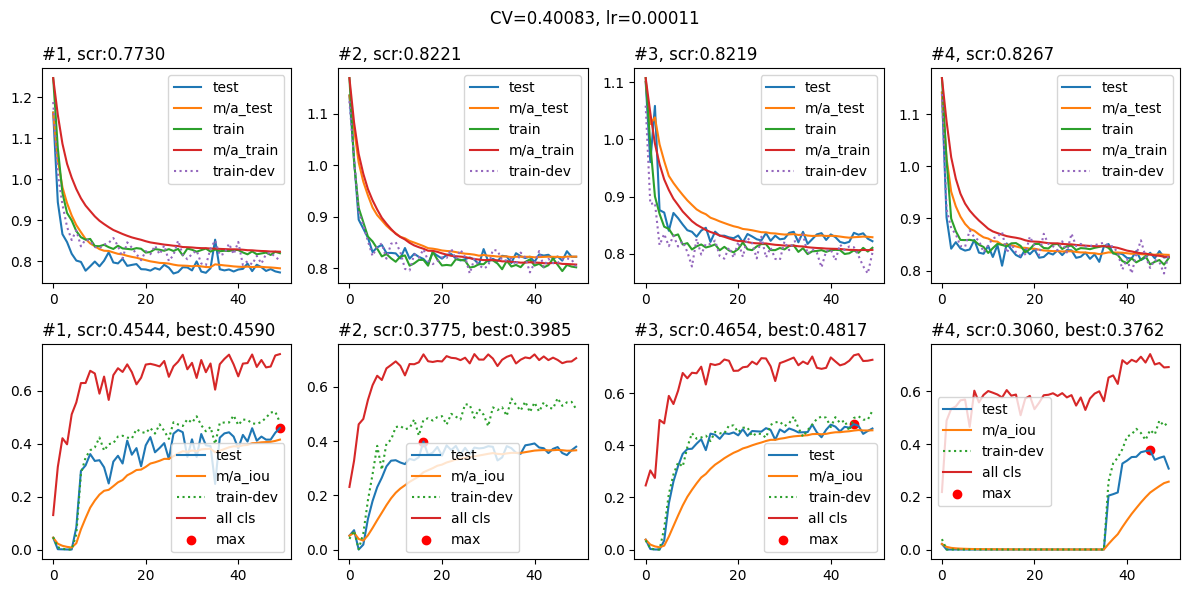

In [11]:
wsi_list = [1,2,3,4]

fig, axs = plt.subplots(2, len(wsi_list), figsize=(12, 6), layout='tight')

BS = 5
N_EPOCHS = 50
LR = 1.1e-04
WD = 1e-04
GAMMA = 0.99

scores_best = []
scores_wsi = []

for i, WSI in enumerate(wsi_list):
    T0 = datetime.now()
    train_loader, test_loader, train_dev_loader = init_dataloaders(WSI, BS)

    model = smp.Unet(encoder_name='mit_b4',
                     encoder_weights='imagenet',
                     decoder_channels=(512, 256, 128, 64, 32),
                     decoder_use_batchnorm=True,
                     classes=3,
                     activation=None)

    model.segmentation_head[2] = nn.Softmax(dim=1)

    # weights = torch.tensor([0.1, 1, 1]).to(device)

    loss_func_dice = smp.losses.DiceLoss(mode='multiclass')
    # loss_func = nn.CrossEntropyLoss(weight=weights)
    loss_func_focal = smp.losses.FocalLoss(mode='multiclass')
    # loss_func = torchvision.ops.focal_loss()

    train_results = train_model(model, loss_func_focal, loss_func_dice, N_EPOCHS, LR, WD, GAMMA, WSI)

    iou_score = test_model(model, loss_func_focal, loss_func_dice)[1]

    scores_wsi.append(iou_score)
    scores_best.append(train_results['best_score'])

    axs[0, i] = axis_loss_set(axs[0, i], train_results)
    axs[1, i] = axis_iou_set(axs[1, i], train_results, iou_score)

    T1 = datetime.now() - T0

    print(f"WSI #{WSI} finished, Time elapsed: {T1}")
    print(f"Best score: {train_results['best_score']:.4f}, model score: {iou_score:.4f}")

mean_score = np.mean(scores_wsi)

fig.suptitle(f'CV={mean_score:.5f}, lr={LR}')
fig.savefig('res_figure.png', dpi=200)